# Optimal execution
## Probabilistic permanent price impact

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = "retina"

In [6]:
def price_step(key, price_old, action, b):
    p = jax.nn.sigmoid(action * b)
    jump = jax.random.bernoulli(key, p)
    jump = (2 * jump - 1)
    price = price_old + jump
    
    return price

In [58]:
T = 100
b = 0.1

key = jax.random.PRNGKey(3141)
key_action, keys_price = jax.random.split(key, 2)
keys_price = jax.random.split(keys_price, T)

price_init = 100

def price_step_scan(price, state):
    key, action = state
    price = price_step(key, price, action, b)
    
    return price, price

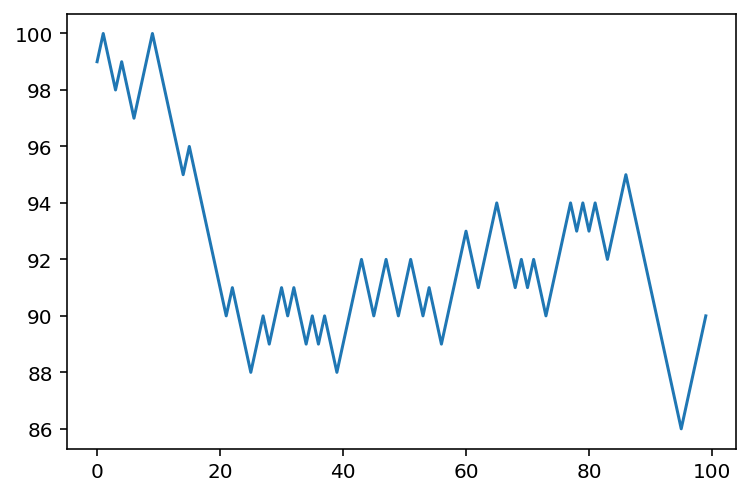

In [59]:
num_actions = 11
actions = jax.random.categorical(key_action, logits=jnp.ones(num_actions), shape=(T,)) - 5

state = (keys_price, actions)
_, price_hist = jax.lax.scan(price_step_scan, price_init, state)

plt.plot(price_hist)

In [62]:
def sample_path(key, price_init, T, b):
    num_actions = 11
    key_action, keys_price = jax.random.split(key, 2)
    keys_price = jax.random.split(keys_price, T)

    actions = jax.random.categorical(key_action, logits=jnp.ones(num_actions), shape=(T,)) - 5
    state = (keys_price, actions)
    _, price_hist = jax.lax.scan(price_step_scan, price_init, state)
    
    return price_hist

sample_paths = jax.vmap(sample_path, in_axes=(0, None, None, None))

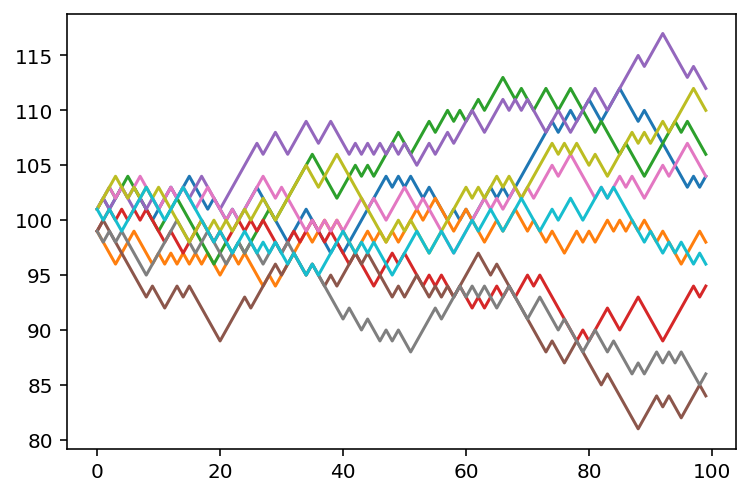

In [75]:
num_paths = 10
keys = jax.random.split(key, num_paths)


b = 0
plt.plot(sample_paths(keys, price_init, T, b).T);